In [1]:
from time import sleep
from random import random
import pandas as pd
import numpy as np
import requests
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import urllib.parse as urlparse
from urllib.parse import parse_qs

In [4]:
# Constants
BASE_URL = 'https://www.flipkart.com/'
SEARCH_QUERY = "headphones"
TOP_N_PRODUCTS = 10
REVIEW_PAGES_TO_SCRAPE_FROM_PER_PRODUCT = 100 #10 Reviews exist per page

In [5]:
SAMPLE_URL = "https://www.flipkart.com/boat-rockerz-400-bluetooth-headset/product-reviews/itm14d0416b87d55?pid=ACCEJZXYKSG2T9GS&lid=LSTACCEJZXYKSG2T9GSVY4ZIC&marketplace=FLIPKART&page=1"
r = requests.get(SAMPLE_URL)    
soup = BeautifulSoup(r.content, 'html.parser') 
print(soup.prettify()[:500])

<!DOCTYPE html>
<html lang="en">
 <head>
  <link href="https://rukminim1.flixcart.com" rel="preconnect"/>
  <link href="//static-assets-web.flixcart.com/fk-p-linchpin-web/fk-cp-zion/css/app_modules.chunk.905c37.css" rel="stylesheet"/>
  <link href="//static-assets-web.flixcart.com/fk-p-linchpin-web/fk-cp-zion/css/app.chunk.4fb0ab.css" rel="stylesheet"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-type"/>
  <meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
  <meta content=


In [6]:
# Extracting all review blocks
## Note col._2wzgFH.K0kLPL means 3 entities namely 'col', ' _2wzgFH' and 'K0kLPL' 
## This is written in HTML as 'col _2wzgFH K0kLPL'
## This can also be seen in Bullet 3

rows = soup.find_all('div',attrs={'class':'col _2wzgFH K0kLPL'})
print(f"Count of rows(reviews):{len(rows)}\n\n\n")
# iteration over all blocks
for row in rows:
    # Print a sample row(review html block)
    # print(f"row:\n{row} \n\n")
    
    # finding all rows within the block
    sub_row = row.find_all('div',attrs={'class':'row'})
        
    # extracting text from 1st and 2nd row
    rating = sub_row[0].find('div').text
    print(f"rating:{rating} \n\n")
    
    summary = sub_row[0].find('p').text
    print(f"summary:{summary} \n\n")
    
    review = sub_row[1].find_all('div')[2].text
    print(f"review:{review} \n\n")
    
    location = sub_row[3].find('p',attrs={'class':'_2mcZGG'}).find_all('span')[1].text
    location = "".join(location.split(",")[1:]).strip()
    print(f"location:{location} \n\n")
    
    date = sub_row[3].find_all('p',attrs={'class':'_2sc7ZR'})[1].text
    print(f"date:{date} \n\n")
    
    
    sub_row_2 = row.find_all('div',attrs={'class':'_1e9_Zu'})[0].find_all('span',attrs={'class':'_3c3Px5'})
    
    upvotes = sub_row_2[0].text
    print(f"upvotes:{upvotes} \n\n")
    
    downvotes = sub_row_2[1].text
    print(f"downvotes:{downvotes} \n\n")
    
    break

Count of rows(reviews):10



rating:5 


summary:Worth every penny 


review:It was nice produt. I like it's design a lot.  It's easy to carry. And.   Looked stylish. 


location:Kadirur 


date:Jan, 2020 


upvotes:4048 


downvotes:303 




In [7]:
def get_popular_product_s_titles_and_urls(search_query : str, popular_products_count_limit : int = None):
    
    search_url = f"{BASE_URL}search?q={search_query}&sort=popularity"
    search_response = requests.get(search_url)
    
    # Pause the loop for 1-3 seconds to simulate natural setting not overwhelm the server with back to back requests without any pause
    # sleep(randint(1,3))
    
    search_html_soup = BeautifulSoup(search_response.content, 'html.parser')
    search_results_products = search_html_soup.find_all('div',attrs={'class':'_4ddWXP'})
    
    product_titles, product_urls = [],[]
    
    product_count = 0
    
    for product in tqdm(search_results_products, desc="Search Results Iteration", position=0, leave=True):
        
        ad_mention_subrow = product.find("div", attrs={"class":"_4HTuuX"})
        
        is_ad = not not ad_mention_subrow
        
        if not is_ad:
            
            title_mention_subrow = product.find("a", attrs={"class":"s1Q9rs"})
            
            product_title = title_mention_subrow["title"]
            product_relative_url = title_mention_subrow["href"]
            product_url = urljoin(BASE_URL,product_relative_url)
            
            parsed_url = urlparse.urlparse(product_url)
            parsed_url_path = parsed_url.path
            parsed_url_path_split = parsed_url_path.split("/")
            parsed_url_path_split[2] = "product-reviews"
            parsed_url_path_modified = "/".join(parsed_url_path_split)
            parsed_url_modified = parsed_url._replace(path=parsed_url_path_modified)
            product_url = parsed_url_modified.geturl()
            
            product_titles.append(product_title)
            product_urls.append(product_url)
            
            product_count += 1
            
            if popular_products_count_limit and (product_count >= popular_products_count_limit):
                break
                
    return product_titles, product_urls

In [8]:
product_titles, product_urls = get_popular_product_s_titles_and_urls(SEARCH_QUERY, TOP_N_PRODUCTS);

Search Results Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

In [9]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["# Products", "# Reviews Per Page", "# Pages", "# Total Reviews Count"]
x.add_row([len(product_urls), 10, REVIEW_PAGES_TO_SCRAPE_FROM_PER_PRODUCT, len(product_urls)*10*REVIEW_PAGES_TO_SCRAPE_FROM_PER_PRODUCT])
print(x)

+------------+--------------------+---------+-----------------------+
| # Products | # Reviews Per Page | # Pages | # Total Reviews Count |
+------------+--------------------+---------+-----------------------+
|     10     |         10         |   100   |         10000         |
+------------+--------------------+---------+-----------------------+


In [10]:
dataset = []

for idx, url in enumerate(tqdm(product_urls, desc='products')):
    # iterating over review pages
    for i in tqdm(range(1,REVIEW_PAGES_TO_SCRAPE_FROM_PER_PRODUCT+1), desc="review pages", position=0, leave=False):
        parsed = urlparse.urlparse(url)
        pid = parse_qs(parsed.query)['pid'][0]
        URL = f"{url}&page={i}"
        
        r = requests.get(URL)
        
        # Pause the loop for 0-1 seconds to simulate natural setting not overwhelm the server with back to back requests without any pause
        sleep(random())
        soup = BeautifulSoup(r.content, 'html.parser') 

        rows = soup.find_all('div',attrs={'class':'col _2wzgFH K0kLPL'})

        for row in rows:

            # finding all rows within the block
            sub_row = row.find_all('div',attrs={'class':'row'})

            # extracting text from 1st 2nd and 4th row
            rating = sub_row[0].find('div').text
            summary = sub_row[0].find('p').text
            summary = summary.strip()
            review = sub_row[1].find_all('div')[2].text
            review = review.strip()
            location=""
            location_row = sub_row[3].find('p',attrs={'class':'_2mcZGG'})
            if location_row:
                location_row = location_row.find_all('span')
                if len(location_row)>=2:
                    location = location_row[1].text
                    location = "".join(location.split(",")[1:]).strip()
            date = sub_row[3].find_all('p',attrs={'class':'_2sc7ZR'})[1].text

            sub_row_2 = row.find_all('div',attrs={'class':'_1e9_Zu'})[0].find_all('span',attrs={'class':'_3c3Px5'})

            upvotes = sub_row_2[0].text
            downvotes = sub_row_2[1].text

            # appending to data
            dataset.append({'product_id':pid, 'product_title':product_titles[idx], 'rating': rating, 'summary': summary, 'review': review, 'location' : location, 'date' : date, 'upvotes' : upvotes, 'downvotes' : downvotes})

products:   0%|          | 0/10 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

ConnectionError: HTTPSConnectionPool(host='www.flipkart.com', port=443): Max retries exceeded with url: /oneplus-bullets-wireless-z2-bluetooth-headset/product-reviews/itm7326ce69c6b07?pid=ACCGC4GNTHDWZJRA&lid=LSTACCGC4GNTHDWZJRA7YTWG8&marketplace=FLIPKART&q=headphones&store=0pm%2Ffcn&srno=s_1_6&otracker=search&fm=organic&iid=0f3dae0c-a6bc-46d7-a833-df22e4b85761.ACCGC4GNTHDWZJRA.SEARCH&ppt=None&ppn=None&ssid=gl2na8fwlc0000001683733134315&qH=edd443896ef5dbfc&page=15 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000021939A76910>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [11]:
df = pd.DataFrame(dataset)

with pd.option_context('display.max_colwidth', -1):
    display(df.head(5))
    display(df.tail(5))

,product_id,product_title,rating,summary,review,location,date,upvotes,downvotes
0,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Mind-blowing purchase,Nice headphone value for money product bass is very good vocal clear build kawlity is very good highly recommend...,Pune,11 months ago,1275,253
1,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Fabulous!,Sound vocals are crysp & clear until 95% (volume)(5/5) Bass is also good(4.5/5) Battery backup is great(5/5) Quality of headphones is great(5/5) Overall it's a great product (for my POV)I literally loved it😍❤‍🔥It's not for pro gamers it's only for Oneplus & Music lovers🎶,Malda,10 months ago,1805,374
2,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Must buy!,"Super Bass An Sound Quality Super 5 ster ,❤️❤️ OnePlus ❤️🔥🔥🔥😎🔥 Super Battery backup Super Powered bass boos an Sound",Purba Bardhaman District,9 months ago,537,114
3,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Great product,"Totally,Worth the amount!!! 💯💯💯I am fully satisfied with the product ❤😍. It's worth evry penny, but i would have been more satisfied if there was a cover for the charging port as well🤧As dust can easily go inside the port. Otherwise great product by oneplus 😄❤❤❤. Ordered and got it delivered before 24 hours. 😄💖I would submit another review after 1 month. Today's 4/7/22",Diphu,10 months ago,1542,364
4,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,4,Nice product,"👉Sound quality is excellent, Bass is awesome, balanced bass and treble,👉Build quality is good but One Plus Z Bass Edition has better build quality in comparison of this,👉Battery backup is awesome, as per commitment it is actual approximately 28 hours,👉Wire texture looks premium quality, very comfortable,👉Overall value for money neckband wireless earphone in this price segment, don't go with bad reviews, its really awesome..",Varanasi,"Apr, 2022",2922,743


,product_id,product_title,rating,summary,review,location,date,upvotes,downvotes
3384,ACCGC4GNTHDWZJRA,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Excellent,One of the best neckband 😍,Barpeta District,10 months ago,3,0
3385,ACCGC4GNTHDWZJRA,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Mind-blowing purchase,Super sound quality and bass 😍😍,Vaishali District,10 months ago,4,0
3386,ACCGC4GNTHDWZJRA,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Highly recommended,Good,Theni Allinagaram,11 months ago,4,0
3387,ACCGC4GNTHDWZJRA,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Fabulous!,Sound Quality is good,Sambalpur District,"Apr, 2022",3,0
3388,ACCGC4GNTHDWZJRA,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Terrific,"One of the best neckband, Sound Quality🔊 is Good and build quality is good, Worth to buy.😊",Pune,"Apr, 2022",12,3


In [12]:
df.shape

(3389, 9)

In [13]:
df['review']=df['review'].apply(lambda x:x.strip('\n')) # To remove '\n' from every review

In [14]:
df.head()

,product_id,product_title,rating,summary,review,location,date,upvotes,downvotes
0,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Mind-blowing purchase,Nice headphone value for money product bass is...,Pune,11 months ago,1275,253
1,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Fabulous!,Sound vocals are crysp & clear until 95% (volu...,Malda,10 months ago,1805,374
2,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Must buy!,"Super Bass An Sound Quality Super 5 ster ,❤️❤️...",Purba Bardhaman District,9 months ago,537,114
3,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Great product,"Totally,Worth the amount!!! 💯💯💯I am fully sati...",Diphu,10 months ago,1542,364
4,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,4,Nice product,"👉Sound quality is excellent, Bass is awesome, ...",Varanasi,"Apr, 2022",2922,743


In [15]:
import string
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer

In [16]:
STOPWORDS=stopwords.words("english") #stopwords are the most common unnecessary words. eg is, he, that, etc.

In [17]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii') # A function to remove emojis from the reviews

In [18]:
import string   
import re

def clean_text(text):
    ps=PorterStemmer()
    
    text=deEmojify(text) # remove emojis
    text_cleaned="".join([x for x in text if x not in string.punctuation]) # remove punctuation
    
    text_cleaned=re.sub(' +', ' ', text_cleaned) # remove extra white spaces
    text_cleaned=text_cleaned.lower() # converting to lowercase
    tokens=text_cleaned.split(" ")
    tokens=[token for token in tokens if token not in STOPWORDS] # Taking only those words which are not stopwords
    text_cleaned=" ".join([ps.stem(token) for token in tokens])
    
    
    return text_cleaned

In [20]:
df['cleaned_reviews']=df['review'].apply(lambda x:clean_text(x))
df.sample(5)

,product_id,product_title,rating,summary,review,location,date,upvotes,downvotes,cleaned_reviews
1606,ACCGC4GN5SQR7ZCZ,"OnePlus Bullets Wireless Z2 with Fast Charge, ...",5,Great product,Very nice nice voice 🤠🤠,Sitamarhi District,"Apr, 2022",3,3,nice nice voic
564,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,1,Did not meet expectations,Not worth of money,Rourkela,11 months ago,0,0,worth money
1549,ACCGC4GN5SQR7ZCZ,"OnePlus Bullets Wireless Z2 with Fast Charge, ...",4,Pretty good,Good,Kadapa,11 months ago,1,0,good
3004,ACCGH7YZY6AHGCHJ,OPPO Enco Buds 2 with 28 hours Battery life & ...,5,Highly recommended,Best wireless earbuds with best battery backup...,Barasat,7 months ago,5,0,best wireless earbud best batteri backup great...
3251,ACCGH7YZY6AHGCHJ,OPPO Enco Buds 2 with 28 hours Battery life & ...,5,Super!,Awesome product i like it always oppo brand my...,Ludhiana,1 month ago,0,0,awesom product like alway oppo brand first pra...


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generating a wordcloud to give a view of the words in the reviews based on their frequency of occurence

In [23]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 153.3/153.3 kB 39.3 kB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


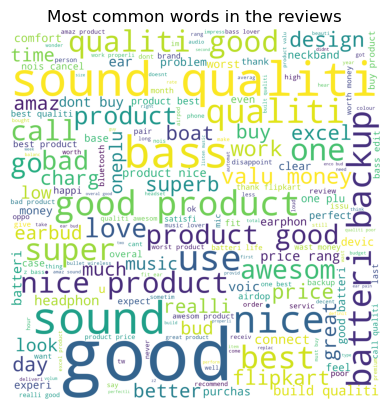

In [24]:
from wordcloud import WordCloud
wordcloud = WordCloud(height=2000, width=2000, background_color='white')
wordcloud = wordcloud.generate(' '.join(df['cleaned_reviews'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in the reviews")
plt.axis('off')
plt.show()

# Analyzing the sentiment of reviews using the library 'vader'

In [26]:
!pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 126.0/126.0 kB 57.0 kB/s eta 0:00:00


In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

~~~
Defining a function to find the sentiment of a review. It will return a dictionary having positive, negative and compound scores.
~~~

In [28]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

# Defining a function to extract only the compound score.

In [29]:
def compound_score(text):
    comp=sentiment_analyzer_scores(text)
    return comp['compound'] # returns the compound score from the dictionary

In [30]:
df['sentiment_score']=df['review'].apply(lambda x:compound_score(x)) # applying on the reviews column to get the score
df.sample(5)

,product_id,product_title,rating,summary,review,location,date,upvotes,downvotes,cleaned_reviews,sentiment_score
2495,ACCG6DS7WDJHGWSH,"boAt Airdopes 161 with ASAP Charge, 10mm Drive...",5,Fabulous!,Worth it at this price bass is so deep and ver...,Rafiganj,"Jan, 2022",1686,430,worth price bass deep clear soundand look also...,0.9770
715,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Great product,The product is very good according to the price,Saiyad Raja,4 days ago,0,0,product good accord price,0.4927
2164,ACCFSDGXX3S6DVBG,boAt Airdopes 131 with upto 60 Hours and ASAP ...,5,Classy product,"nice product sound and game awsome ,,nice bate...",Dibrugarh,4 months ago,25,3,nice product sound game awsom nice bateri backup,0.6808
2899,ACCGH7YZY6AHGCHJ,OPPO Enco Buds 2 with 28 hours Battery life & ...,5,Mind-blowing purchase,Best product to buy in this price money. If yo...,South Twenty Four Parganas District,7 months ago,7,1,best product buy price money find youtub tell ...,0.2481
418,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,1,Worthless,Good one plus wireless z2 BluetoothTigar.....F...,,7 months ago,0,0,good one plu wireless z2 bluetoothtigarfarmaan...,0.4404


~~~
We have got the sentiment score. Now categorizing the reviews based on the score into postive, negative and neutral using the below conditions.
~~~

In [31]:
def sentiment_category(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

In [32]:
df['review_category']=df['sentiment_score'].apply(lambda x:sentiment_category(x))
df.sample(5)

,product_id,product_title,rating,summary,review,location,date,upvotes,downvotes,cleaned_reviews,sentiment_score,review_category
3112,ACCGH7YZY6AHGCHJ,OPPO Enco Buds 2 with 28 hours Battery life & ...,1,Horrible,"Please think before buying,This ear bud is not...",Ajhuwa,7 months ago,1,0,pleas think buyingthi ear bud comfort ear cann...,-0.3601,negative
969,ACCGF4JZHYTERVTY,OnePlus Bullets Wireless Z2 Bluetooth Headset,5,Great product,good product.,Chennai,7 days ago,0,0,good product,0.4404,positive
1038,ACCGC4GN5SQR7ZCZ,"OnePlus Bullets Wireless Z2 with Fast Charge, ...",5,Terrific purchase,This z2 is the actual bass edition. 1. Sound ...,Isnapur,"Apr, 2022",115,6,z2 actual bass edit 1 sound qualiti 552 bass 5...,0.0000,neutral
1068,ACCGC4GN5SQR7ZCZ,"OnePlus Bullets Wireless Z2 with Fast Charge, ...",5,Best in the market!,"Very Good Quality.Sound Quality is very Good,V...",North Twenty Four Parganas District,"Apr, 2022",29,4,good qualitysound qualiti goodvalu money,0.4927,positive
1796,ACCGC4GN5SQR7ZCZ,"OnePlus Bullets Wireless Z2 with Fast Charge, ...",5,Classy product,This product osome.,Dinhata,5 days ago,0,0,product osom,0.0000,neutral


# Plotting a distribution of the review categories

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Reviews Category')

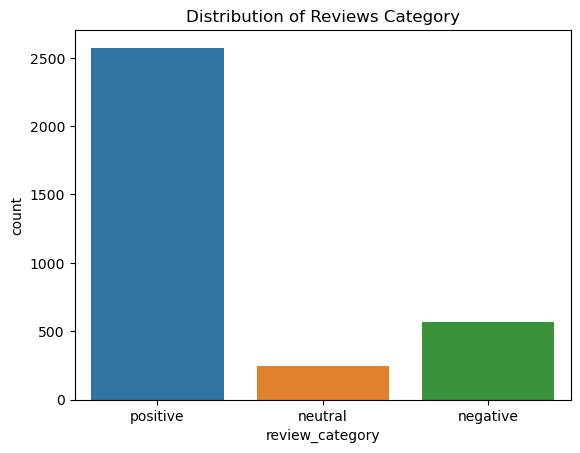

In [33]:
sns.countplot(df['review_category']).set_title("Distribution of Reviews Category")

In [34]:
positive_reviews=df.loc[df['review_category']=='positive','cleaned_reviews'].tolist() # extracting all positive reviews and converting to a list
positive_reviews[0:5]

['nice headphon valu money product bass good vocal clear build kawliti good highli recommend',
 'sound vocal crysp clear 95 volume55 bass also good455 batteri backup great55 qualiti headphon great55 overal great product povi liter love itit pro gamer oneplu music lover',
 'super bass sound qualiti super 5 ster oneplu super batteri backup super power bass boo sound',
 'totallyworth amount fulli satisfi product worth evri penni would satisfi cover charg port wella dust easili go insid port otherwis great product oneplu order got deliv 24 hour would submit anoth review 1 month today 4722',
 'sound qualiti excel bass awesom balanc bass treblebuild qualiti good one plu z bass edit better build qualiti comparison thisbatteri backup awesom per commit actual approxim 28 hourswir textur look premium qualiti comfortableoveral valu money neckband wireless earphon price segment dont go bad review realli awesom']

In [35]:
negative_reviews=df.loc[df['review_category']=='negative','cleaned_reviews'].tolist() # extracting all negative reviews and converting to a list
negative_reviews[0:5]

['worst respons flipkart receiv product problem one side speaker work told give replac product r refund till respond guy dont buy flipkart',
 'osm ',
 'bad product seriou connect issu want return return button work took back front page everytim',
 'one hear low sound',
 'think bullet z bass havenbut bullet z2 ultim bass luv']

# Generating wordclouds separately for positive and negative reviews

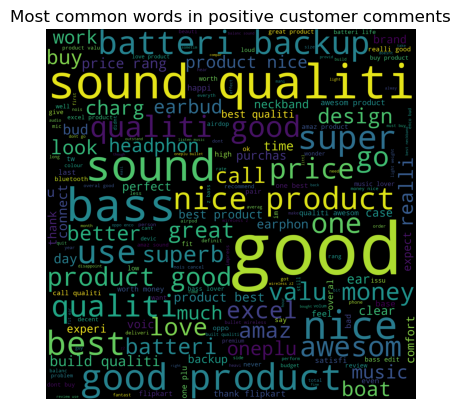

In [36]:
from wordcloud import WordCloud
wordcloud = WordCloud(height=2000, width=2000, background_color='black')
wordcloud = wordcloud.generate(' '.join(df.loc[df['review_category']=='positive','cleaned_reviews'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in positive customer comments")
plt.axis('off')
plt.show()

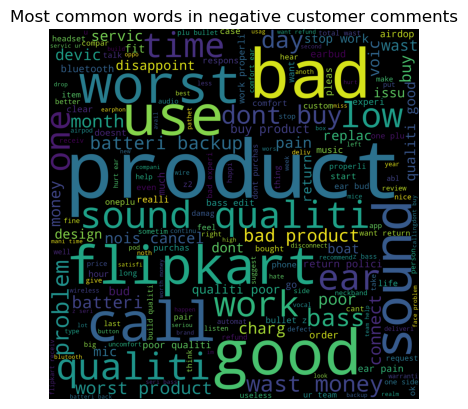

In [37]:
from wordcloud import WordCloud
wordcloud = WordCloud(height=2000, width=2000, background_color='black')
wordcloud = wordcloud.generate(' '.join(df.loc[df['review_category']=='negative','cleaned_reviews'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in negative customer comments")
plt.axis('off')
plt.show()

# Unigrams
Unigrams are just individual words

In [38]:
from collections import Counter

# Defining a function to get the most common words

In [39]:
def getMostCommon(reviews_list,topn=20):
    reviews=" ".join(reviews_list)
    tokenised_reviews=reviews.split(" ")
    
    
    freq_counter=Counter(tokenised_reviews)
    return freq_counter.most_common(topn) # return words with the highest frequencies

In [40]:
top_20_positive_review_words=getMostCommon(positive_reviews,20)
top_20_positive_review_words

[('good', 1307),
 ('product', 946),
 ('qualiti', 915),
 ('sound', 777),
 ('nice', 527),
 ('bass', 499),
 ('', 471),
 ('best', 393),
 ('batteri', 330),
 ('price', 242),
 ('use', 239),
 ('backup', 235),
 ('one', 232),
 ('awesom', 228),
 ('money', 198),
 ('super', 192),
 ('buy', 178),
 ('go', 172),
 ('amaz', 156),
 ('love', 152)]

In [41]:
top_20_negative_review_words=getMostCommon(negative_reviews,20)
top_20_negative_review_words

[('product', 230),
 ('qualiti', 161),
 ('bad', 142),
 ('sound', 118),
 ('good', 107),
 ('worst', 95),
 ('buy', 89),
 ('ear', 85),
 ('work', 77),
 ('dont', 74),
 ('use', 71),
 ('flipkart', 67),
 ('batteri', 67),
 ('money', 67),
 ('call', 66),
 ('wast', 66),
 ('bass', 64),
 ('one', 61),
 ('poor', 58),
 ('return', 51)]

# Defining a function to produce a barplot of the most common words

In [42]:
def plotMostCommonWords(reviews_list,topn=20,title="Common Review Words",color="blue",axis=None): #default number of words is given as 20
    top_words=getMostCommon(reviews_list,topn=topn)
    data=pd.DataFrame()
    data['words']=[val[0] for val in top_words]
    data['freq']=[val[1] for val in top_words]
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title+" top "+str(topn))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title+" top "+str(topn))

# Using the above function, to produce barplots for positive and negative reviews separately

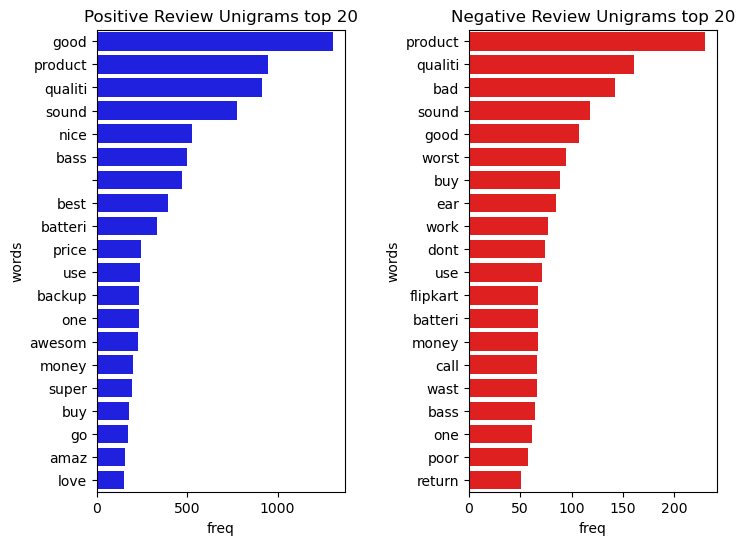

In [43]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 8,6 ## Sets the heigth and width of image


fig,ax=plt.subplots(1,2)
fig.subplots_adjust(wspace=0.5) #Adjusts the space between the two plots
plotMostCommonWords(positive_reviews,20,"Positive Review Unigrams",axis=ax[0])

plotMostCommonWords(negative_reviews,20,"Negative Review Unigrams",color="red",axis=ax[1])

~~~
A unigram will not give us a clear understanding as to what is the customer trying to tell. Hence, we use bigrams.
~~~

# Bigrams
Bigrams are a combination of 2 words

Defining a function to create n-grams. It can be a combination of 2,3,4 or more words. This number can be given as an input to the function argument.

In [44]:
def generateNGram(text,n):
    tokens=text.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ["_".join(ngram) for ngram in ngrams]

# Creating bigrams for postive and negative reviews separately.

In [45]:
positive_reviews_bigrams=[" ".join(generateNGram(review,2)) for review in positive_reviews]
negative_reviews_bigrams=[" ".join(generateNGram(review,2)) for review in negative_reviews]
positive_reviews_bigrams[:5]

['nice_headphon headphon_valu valu_money money_product product_bass bass_good good_vocal vocal_clear clear_build build_kawliti kawliti_good good_highli highli_recommend',
 'sound_vocal vocal_crysp crysp_clear clear_95 95_volume55 volume55_bass bass_also also_good455 good455_batteri batteri_backup backup_great55 great55_qualiti qualiti_headphon headphon_great55 great55_overal overal_great great_product product_povi povi_liter liter_love love_itit itit_pro pro_gamer gamer_oneplu oneplu_music music_lover',
 'super_bass bass_sound sound_qualiti qualiti_super super_5 5_ster ster_oneplu oneplu_super super_batteri batteri_backup backup_super super_power power_bass bass_boo boo_sound',
 'totallyworth_amount amount_fulli fulli_satisfi satisfi_product product_worth worth_evri evri_penni penni_would would_satisfi satisfi_cover cover_charg charg_port port_wella wella_dust dust_easili easili_go go_insid insid_port port_otherwis otherwis_great great_product product_oneplu oneplu_order order_got got_

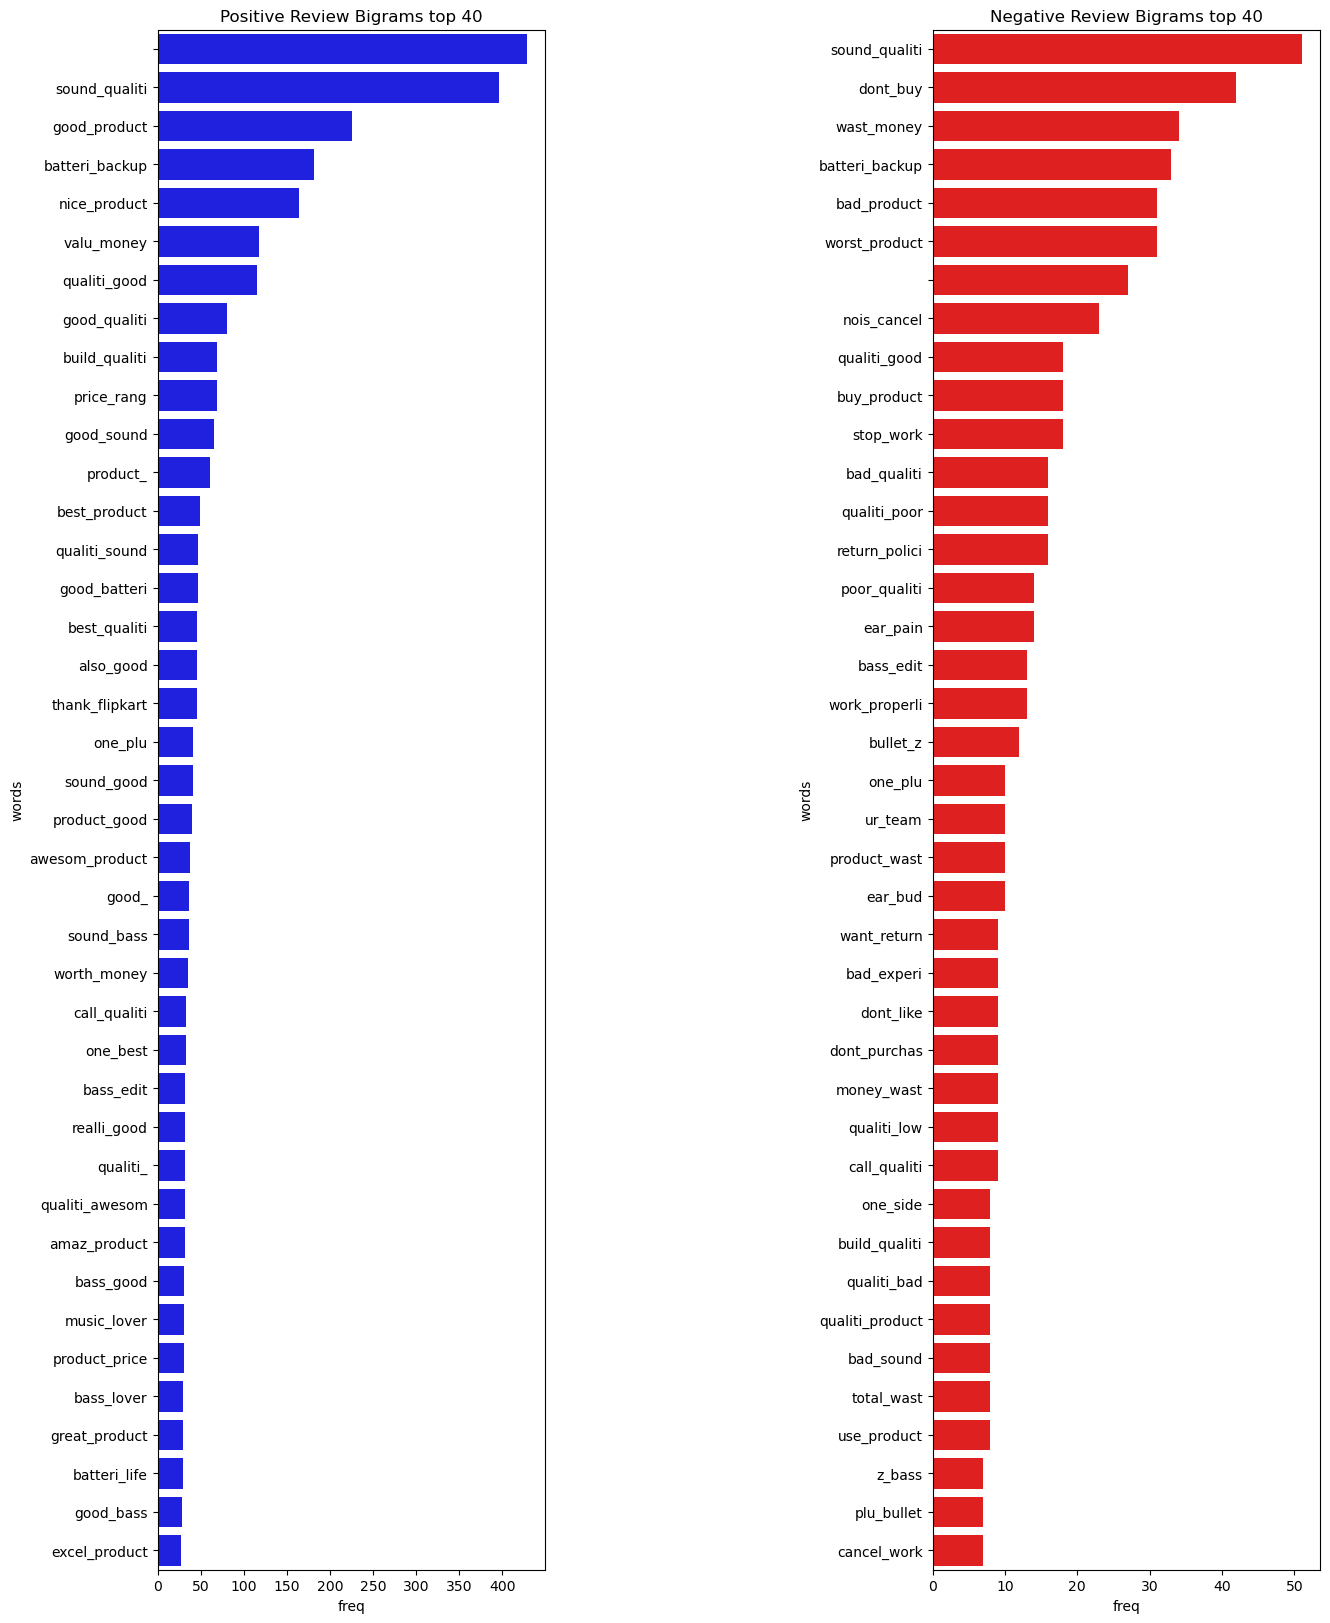

In [46]:
rcParams['figure.figsize'] = 15,20
fig,ax=plt.subplots(1,2)
fig.subplots_adjust(wspace=1)
plotMostCommonWords(positive_reviews_bigrams,40,"Positive Review Bigrams",axis=ax[0])

plotMostCommonWords(negative_reviews_bigrams,40,"Negative Review Bigrams",color="red",axis=ax[1])

# From the above barplot, we can see that the most common bigrams in positive reviews are Sound_quality,good_product, nice_product, value_money, batter_backup, etc. The most common bigrams in negative reviews are Don't_buy, Waste_money, worst_product, dont_buy, poor_quality, etc.